In [1]:
import pandas as pd
import seaborn as sns
sns.set()
import numpy as np
import matplotlib.pyplot as plt
import py_pcha

# Get data

In [2]:
# Basic features
def get_basic_features(path):
    features, feature_names = [], []
    for stat in ["BVP", "HR", "EDA", "TEMP"]:
        signal = pd.read_csv(f"{path}/{stat}.csv")[stat]
        features += [signal.min(), signal.max(), signal.mean(), signal.std()]
        feature_names += [f"{stat}_{f}" for f in ["min", "max", "mean", "std"]]
    return feature_names, features

metadata = pd.read_csv("metadata.csv")
basic_ds = []
for path in metadata['Path']:
    feature_names, features = get_basic_features(path)
    basic_ds.append(features)
    
basic_ds = pd.DataFrame(basic_ds, columns = feature_names)

# Archetypal Analysis - Basic features

Variance explained: 0.9801399831642499


<Figure size 1000x1000 with 0 Axes>

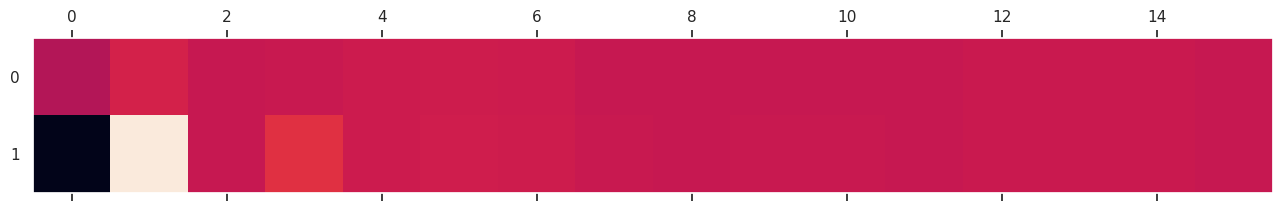

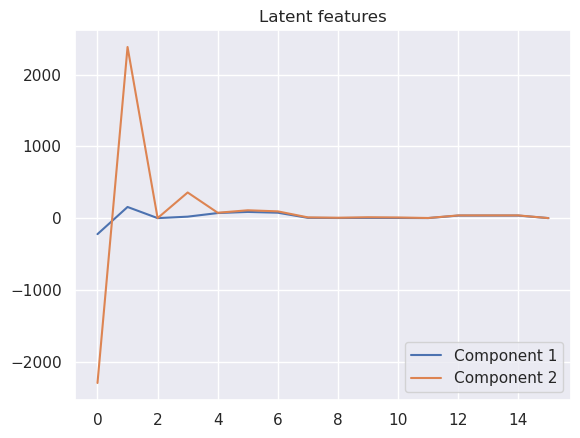

In [3]:
X = basic_ds
n_components = 2

# Does not require that you center data
XC, S, C, SSE, varexpl = py_pcha.PCHA(np.asarray(X.T), noc=n_components, delta=0.1)
S = np.asarray(S)
C = np.asarray(C)

'''
    Output
    ------
    XC : numpy.2darray
        I x noc feature matrix (i.e. XC=X[:,I]*C forming the archetypes)
        the components

    S : numpy.2darray
        noc X n matrix, S>=0 |S_j|_1=1
        the weights

    C : numpy.2darray
        x x noc matrix, C>=0 |c_j|_1=1

    SSE : float
        Sum of Squared Errors
'''

X_hat = X.T @ C @ S
L = 0.5*np.linalg.norm(X.T-X_hat)**2
components = np.asarray(XC.T)

print(f"Variance explained: {varexpl}")

plt.figure(figsize=(10, 10))
plt.matshow(components,aspect='auto')
plt.grid(False)
plt.show()

plt.figure()
plt.title("Latent features")
for i in range(components.shape[0]):
    plt.plot(components[i, :], label=f"Component {i+1}")
plt.legend(loc='lower right')
plt.show()

# Archetypal Analysis - Raw data

## Get raw signals

In [5]:
def get_standardized_signals(stat, n=None, last = True):
    if not n:
        n = metadata[['EDA_n', 'BVP_n', 'HR_n', 'TEMP_n']].min()[stat+'_n']

    raw_ds, raw_ds_ph1, raw_ds_ph2, raw_ds_ph3 = [], {}, {}, {}
    for path in metadata['Path']:
        
        signal = pd.read_csv(f"{path}/{stat}.csv")[stat]
        if last:
            signal = signal.values[-n:]
        else:
            signal = signal.values[:n]
        
        raw_ds.append(signal)
        if path.endswith("phase1"): raw_ds_ph1[path] = signal 
        elif path.endswith("phase2"): raw_ds_ph2[path] = signal 
        elif path.endswith("phase3"): raw_ds_ph3[path] = signal 
    
    raw_ds = pd.DataFrame(raw_ds, index=metadata['Path'])
    raw_ds_ph1 = pd.DataFrame(raw_ds_ph1.values(), index=raw_ds_ph1.keys())
    raw_ds_ph2 = pd.DataFrame(raw_ds_ph2.values(), index=raw_ds_ph2.keys())
    raw_ds_ph3 = pd.DataFrame(raw_ds_ph3.values(), index=raw_ds_ph3.keys())

    return raw_ds, raw_ds_ph1, raw_ds_ph2, raw_ds_ph3

# Get raw HR signal for each phase and combined
raw_HR, raw_HR_ph1, raw_HR_ph2, raw_HR_ph3 = get_standardized_signals("HR")
raw_EDA, raw_EDA_ph1, raw_EDA_ph2, raw_EDA_ph3 = get_standardized_signals("EDA")
raw_TEMP, raw_TEMP_ph1, raw_TEMP_ph2, raw_TEMP_ph3 = get_standardized_signals("TEMP")
raw_BVP, raw_BVP_ph1, raw_BVP_ph2, raw_BVP_ph3 = get_standardized_signals("BVP")

## AA on raw HR - All phases

Variance explained: 0.9960869969096702


<Figure size 1000x1000 with 0 Axes>

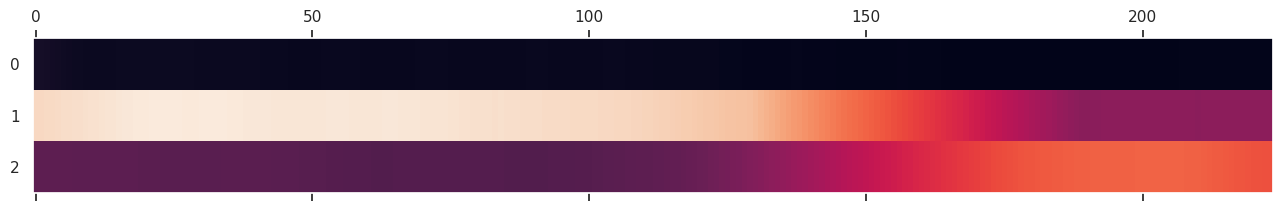

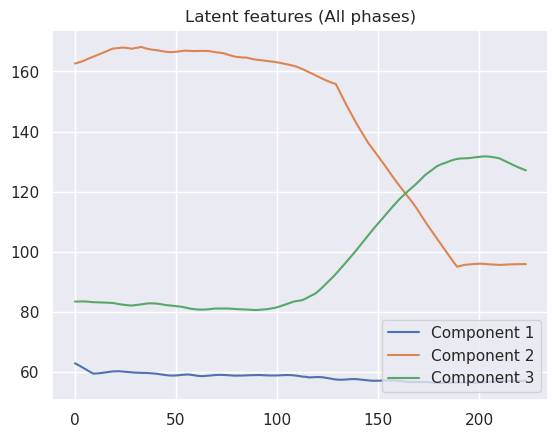

In [107]:
n_components = 3

X = raw_HR
XC, S, C, SSE, varexpl = py_pcha.PCHA(np.asarray(X.T), noc=n_components, delta=0.1)
S = np.asarray(S)
C = np.asarray(C)
X_hat = X.T @ C @ S
L = 0.5*np.linalg.norm(X.T-X_hat)**2
components = np.asarray(XC.T)

print(f"Variance explained: {varexpl}")

plt.figure(figsize=(10, 10))
plt.matshow(components,aspect='auto')
plt.grid(False)
plt.show()

plt.figure()
plt.title("Latent features (All phases)")
for i in range(components.shape[0]):
    plt.plot(components[i, :], label=f"Component {i+1}")
plt.legend(loc='lower right')
plt.show()

In [138]:
X_hat.values[:, i].shape

(224,)

HR


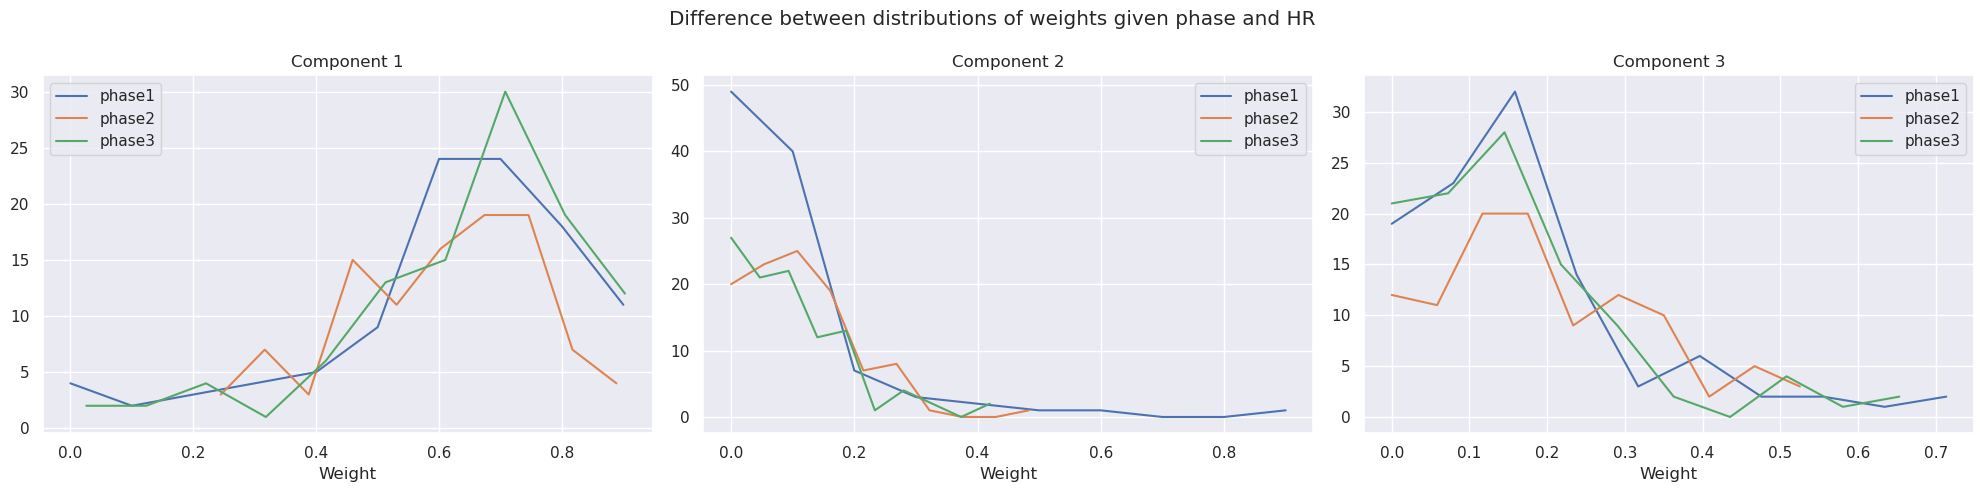

Weight's for resting are different for component 1 with p.value 0.003
Weight's for resting are different for component 2 with p.value 0.036
Weight's for resting are different for component 3 with p.value 0.025

TEMP


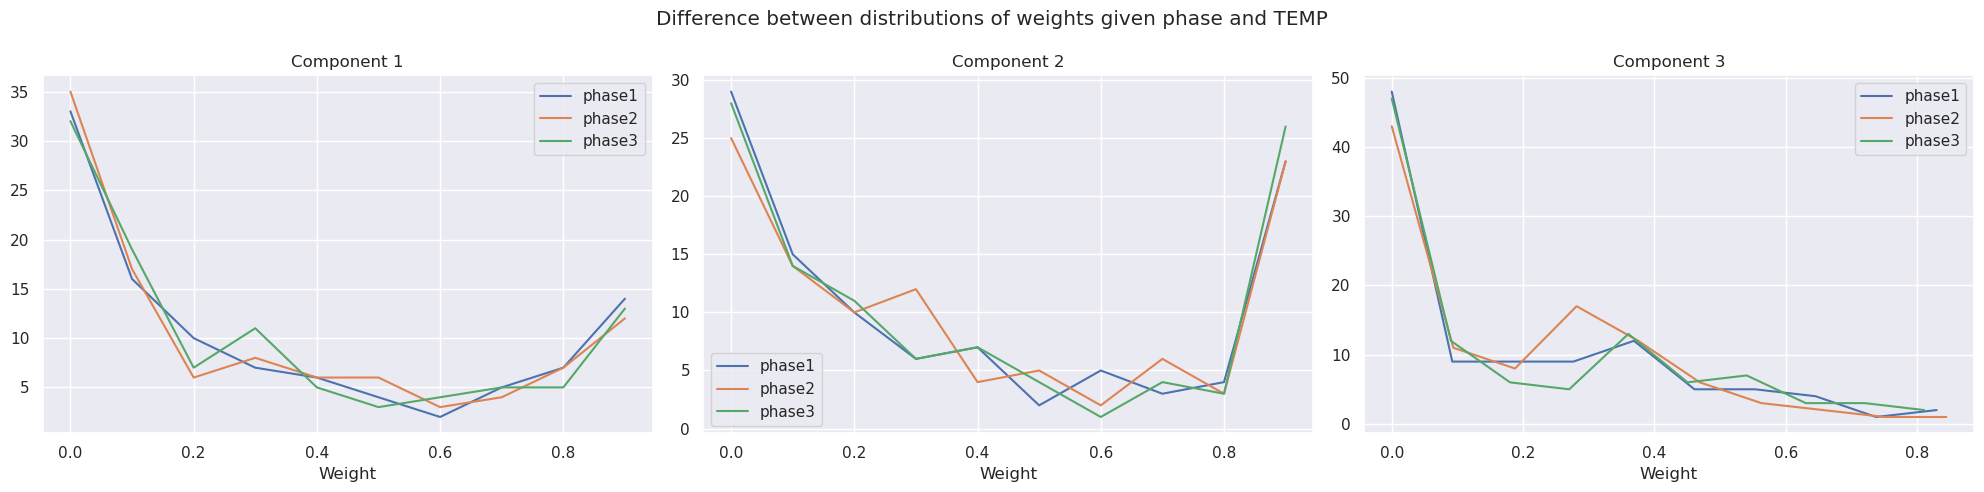


EDA


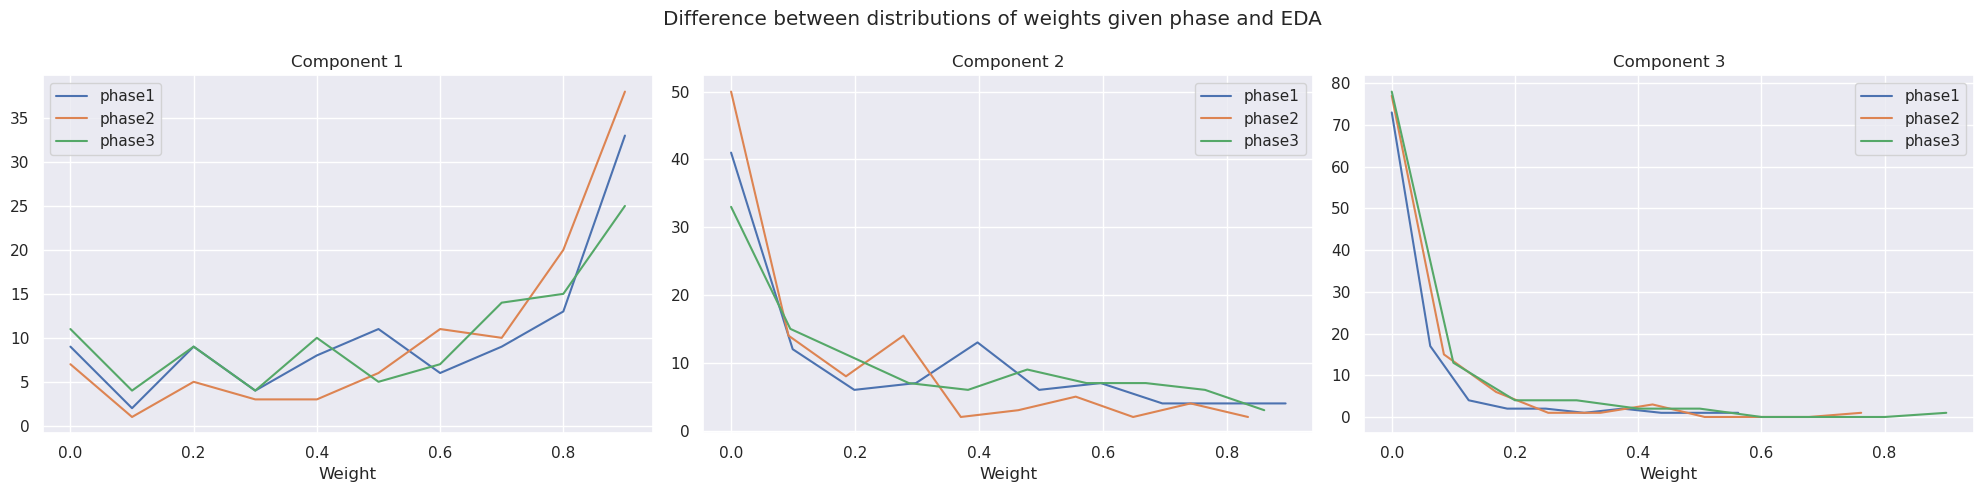

Weight's for resting are different for component 1 with p.value 0.015
Weight's for resting are different for component 2 with p.value 0.002



In [169]:
#C.shape what does c do?


from scipy.stats import kruskal

def get_weights(stat, n_comp = 3):
    
    raw_ds, _, _, _ = get_standardized_signals(stat)
    
    X = raw_ds.values
    XC, S, C, SSE, varexpl = py_pcha.PCHA(np.asarray(X.T), noc=n_comp, delta=0.1)
    S = np.asarray(S)
    C = np.asarray(C)
    X_hat = X.T @ C @ S
    L = 0.5*np.linalg.norm(X.T-X_hat)**2
    components = np.asarray(XC.T)
    
    return X, XC, S, C, X_hat, L, components



def plot_reconstruction(X, X_hat, stat):
    nrows = 2
    ncols = 8
    nshow = 100
    Xnew = X.values if type(X) == pd.DataFrame else X
    Xhatnew = X_hat.values if type(X_hat) == pd.DataFrame else X_hat
    fig, axs = plt.subplots(ncols = ncols, nrows=nrows)
    fig.set_figwidth(ncols*2)
    fig.set_figheight(nrows)
    for i in range(nrows):
        for j in range(ncols):
            idx = i*ncols+j
            observed = Xnew[idx]
            reconstructed = Xhatnew[:, idx]
            axs[i, j].plot(observed[-nshow:])
            axs[i, j].plot(reconstructed[-nshow:])
            axs[i, j].set_yticks([])
            axs[i, j].set_xticks([])

    fig.suptitle(f"Observed and reconstructed signal of {stat}")
    plt.show()
    
def plot_weight_dist(S, stat):
    W = S.T
    n_comp = W.shape[1]
    fig, axs = plt.subplots(nrows=1, ncols=n_comp)
    fig.suptitle(f"Difference between distributions of weights given phase and {stat}")
    fig.set_figwidth(20)
    fig.set_figheight(5)
    phases = sorted(metadata['Phase'].unique())
    for j in range(n_comp):
        dists = []
        for i, phase in enumerate(phases):
            idxs = metadata['Phase'] == phase
            hist, bin_edges = np.histogram(W[idxs, j])
            axs[j].plot(bin_edges[:-1], hist, label=phase)
            
        #axs[j].hist(dists, label = phases)
        axs[j].set_title(f"Component {j+1}")
        axs[j].set_xlabel("Weight")
        axs[j].legend()
    
    plt.tight_layout()    
    plt.savefig(f"figures/weight_dist_{stat}_{n_comp}comps_AA.png")
    plt.show()

def test_eq_dist(S, test_phases=True, test_resting=True, test_cohorts=True, print_only_difference=True):
    
    def test_dist(col):
        dists = []
        cols = sorted(list(set(x.split('/')[0] for x in metadata['Cohort'].unique())))
        for i, val in enumerate(cols):
            idxs = metadata[col] == val
            dists.append(W[idxs, j])
        return kruskal(*dists)
    
    def pretty_print(pval, test_name, j):
        if pval < 0.05:
            print(f"Weight's for {test_name} are different for component {j+1} with p.value {round(pval, 3)}")
        elif not print_only_difference:
            print(f"Weight's for {test_name} are not different for component {j+1}")
        
    W = S.T   
    n_comp = W.shape[1]
    components = np.arange(n_comp)
    for j in components:
        
        
        if test_phases:
            test = test_dist("Phase")
            pretty_print(test.pvalue, "phases", j)


        if test_resting:
            dists = [W[metadata['Phase'].isin(["phase1", "phase3"]), j],
                     W[metadata['Phase']=="phase2", j]]

            test = kruskal(*dists)
            pretty_print(test.pvalue, "resting", j)
                
        if test_cohorts:
            test = test_dist("Cohort")
            pretty_print(test.pvalue, "cohorts", j)
            
for stat in ["HR", "TEMP", "EDA"]:
    print(stat)
    X, XC, S, C, X_hat, L, components = get_weights(stat, 3)   
    #plot_reconstruction(X, X_hat, stat)
    plot_weight_dist(S, stat)
    test_eq_dist(S)
    print()



## AA on all signals - All phases

In [ ]:
def find_weights(stat, n_comp = 3, seed=100, init='random', solver='cd', phase=None):
    #normalize = True if stat=='BVP' else False
    #raw_ds, scaler = get_standardized_signals(stat, with_scaling=normalize)
    if phase is None:
        paths = metadata['Path']
    else:
        paths = metadata.loc[metadata['Phase'] == phase]['Path']
        
    raw_ds = get_standardized_signals(stat, paths = paths)
    X = raw_ds.values
    model = NMF(n_components=n_comp, random_state=seed, init=init, solver=solver, max_iter=400)
    W = model.fit_transform(X)
    H = model.components_
    
    return (X, W, H, model)

## AA on raw signals - For each phase

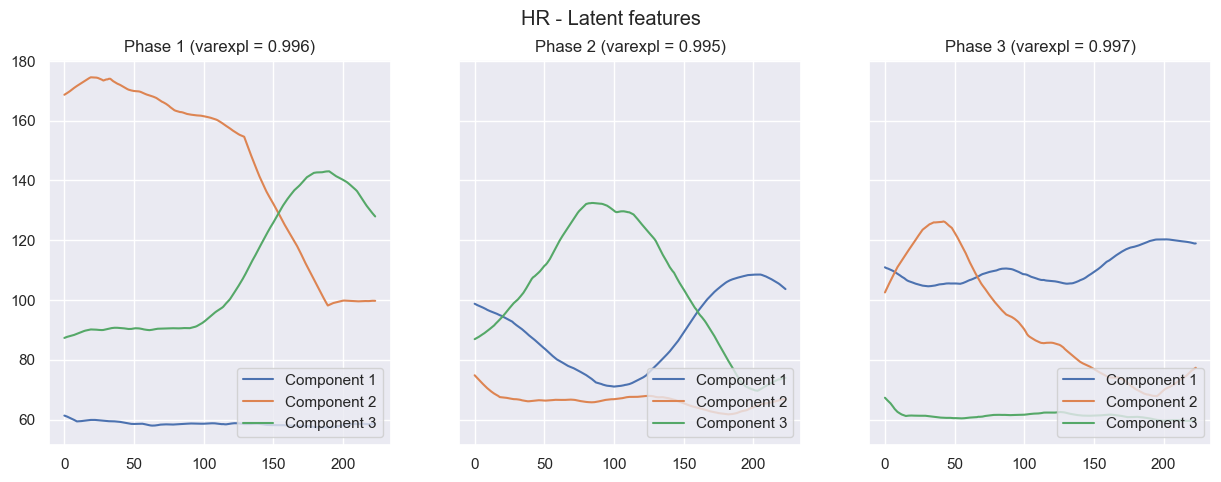

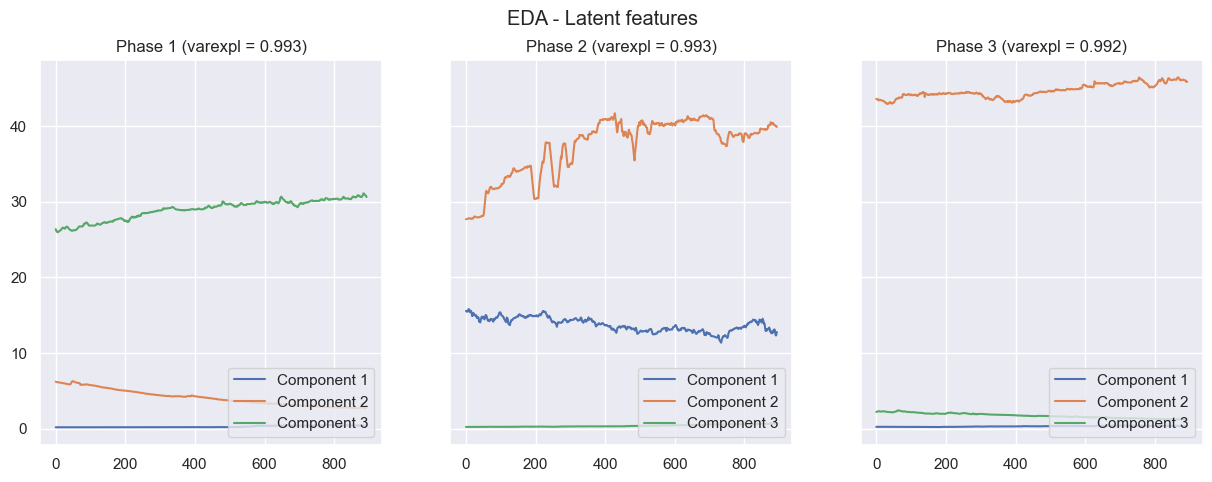

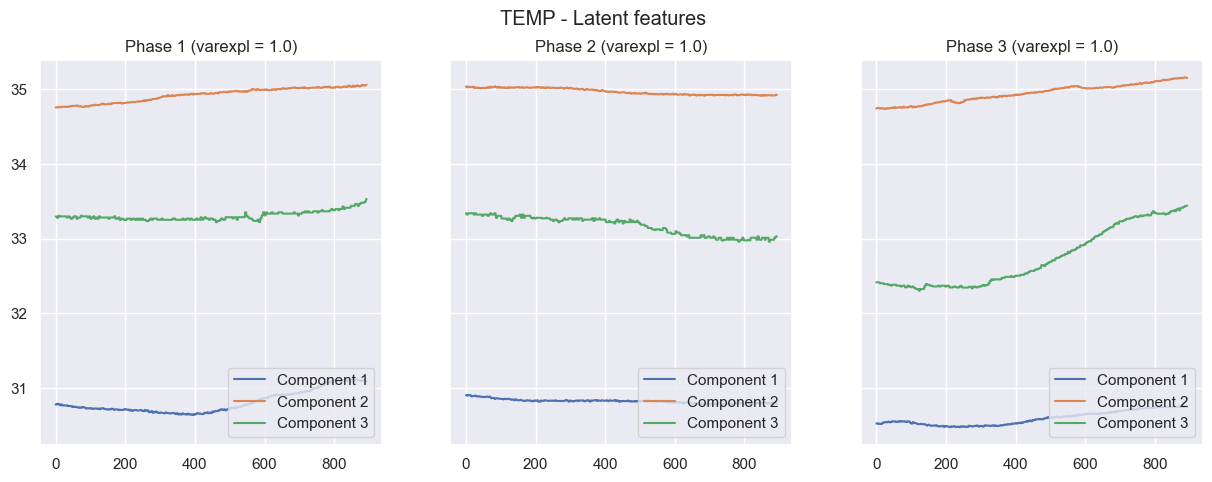

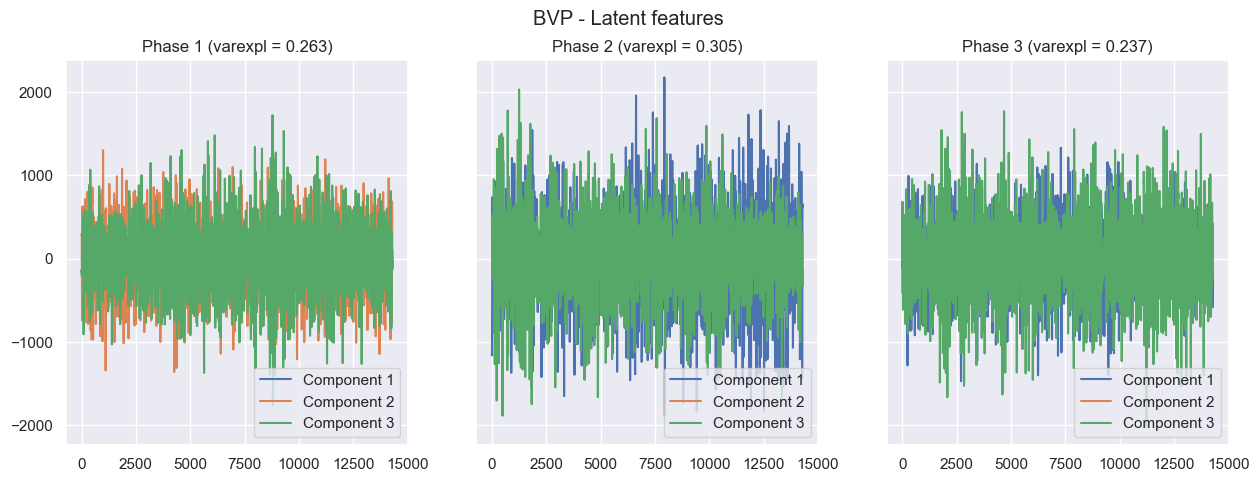

In [26]:
n_components = 3

HR_phases = [raw_HR_ph1, raw_HR_ph2, raw_HR_ph3]
EDA_phases = [raw_EDA_ph1, raw_EDA_ph2, raw_EDA_ph3]
TEMP_phases = [raw_TEMP_ph1, raw_TEMP_ph2, raw_TEMP_ph3]
BVP_phases = [raw_BVP_ph1, raw_BVP_ph2, raw_BVP_ph3]

def plot_latent_features_each_phase(stat_name, stat_phases):
    fig, ax = plt.subplots(1, 3, figsize=(15,5),sharex=False, sharey=True)
    fig.suptitle(f"{stat_name} - Latent features")
    for phase in range(len(stat_phases)):
        X = stat_phases[phase]
        
        # AA
        XC, S, C, SSE, varexpl = py_pcha.PCHA(np.asarray(X.T), noc=n_components, delta=0.1)
        S = np.asarray(S)
        C = np.asarray(C)
        X_hat = X.T @ C @ S
        L = 0.5*np.linalg.norm(X.T-X_hat)**2
        components = np.asarray(XC.T)

        # Plot
        ax[phase].set_title(f"Phase {phase+1} (varexpl = {round(varexpl, 3)})")
        for i in range(components.shape[0]):
            ax[phase].plot(components[i, :], label=f"Component {i+1}")
        ax[phase].legend(loc='lower right')

plot_latent_features_each_phase("HR", HR_phases)
plot_latent_features_each_phase("EDA", EDA_phases)
plot_latent_features_each_phase("TEMP", TEMP_phases)
plot_latent_features_each_phase("BVP", BVP_phases)

## AA on raw signals - Different number of components

In [30]:
n_components_list = range(1,6)

def plot_different_n_components(stat_phase_list, phase, noc_int):

    fig, ax = plt.subplots(1, len(noc_int), figsize=(20,5),sharex=False, sharey=True)
    fig.suptitle(f'Phase {phase}')
    fig.subplots_adjust(top=0.8)
    X = stat_phase_list[phase-1]

    for j, n_components in enumerate(noc_int):

        # AA
        XC, S, C, SSE, varexpl = py_pcha.PCHA(np.asarray(X.T), noc=n_components, delta=0.1)
        S = np.asarray(S)
        C = np.asarray(C)
        X_hat = X.T @ C @ S
        L = 0.5*np.linalg.norm(X.T-X_hat)**2
        components = np.asarray(XC.T)

        # Plot
        ax[j].set_title(f"No. of components: {n_components} \n (varexpl = {round(varexpl, 3)})")
        for i in range(components.shape[0]):
            ax[j].plot(components[i, :], label=f"Component {i+1}")
        #ax[j].legend(loc='lower right')


## HR

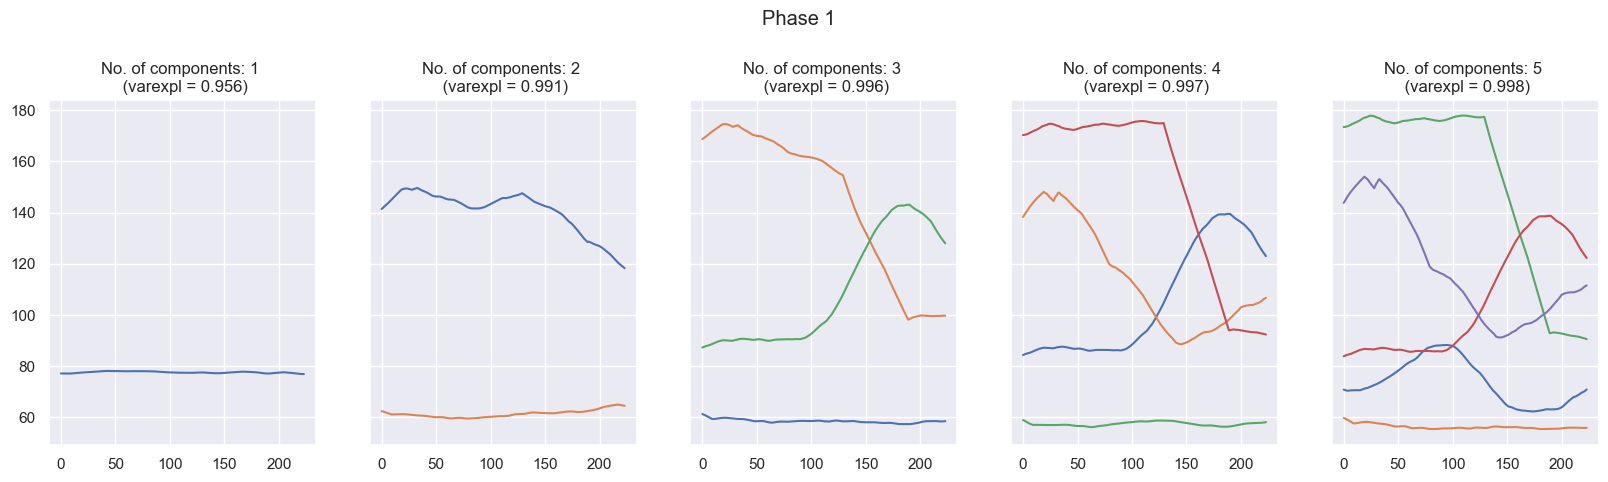

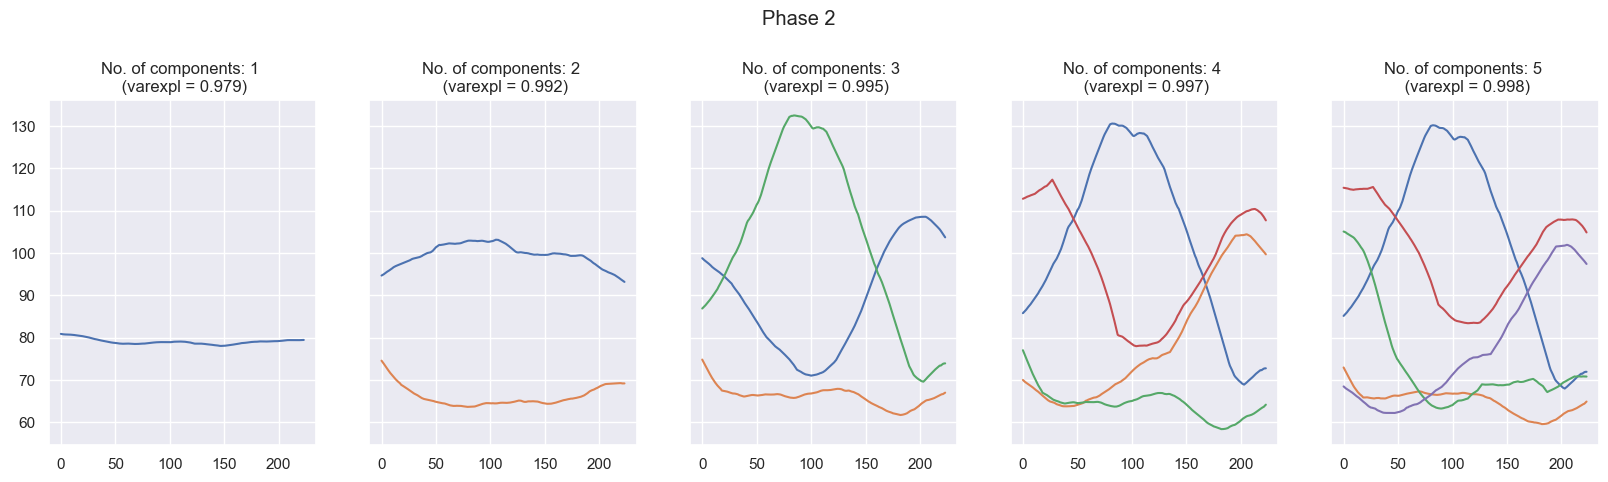

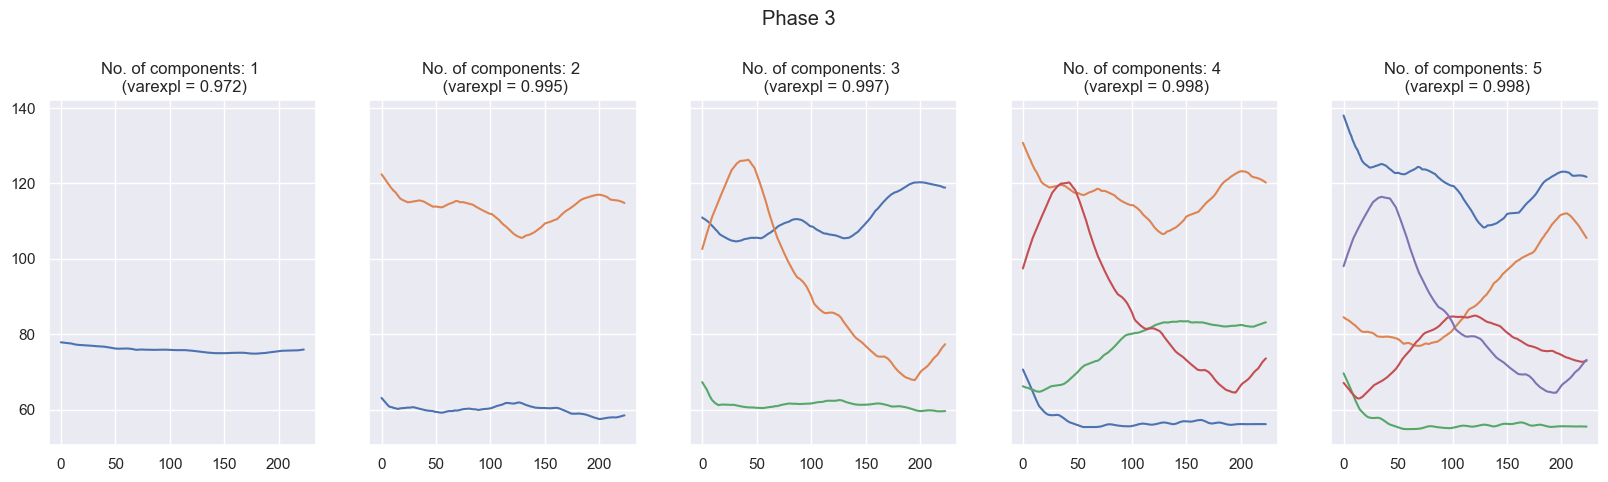

In [32]:
for i in range(1,4):
    plot_different_n_components(HR_phases, i, n_components_list)

## EDA

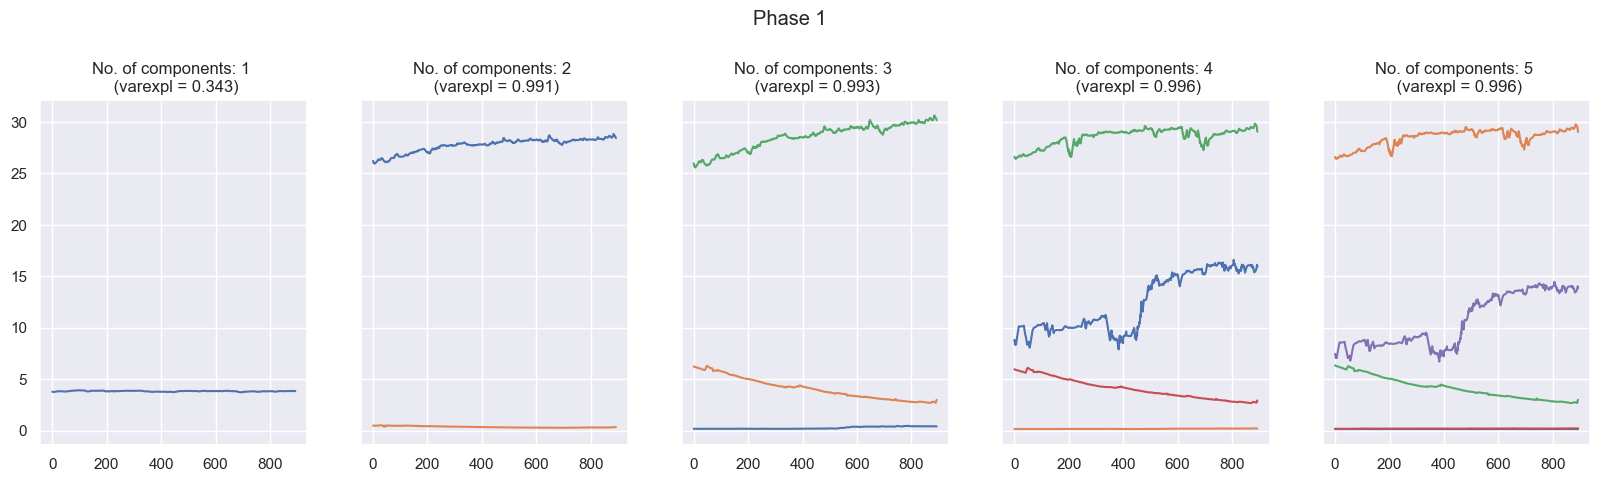

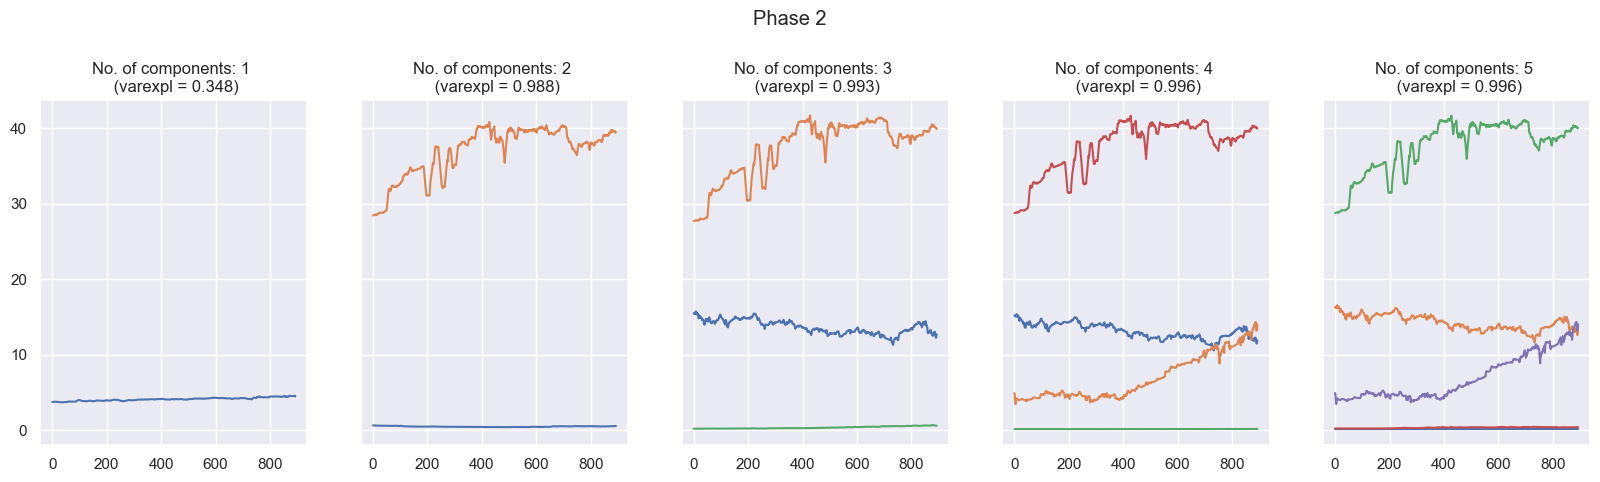

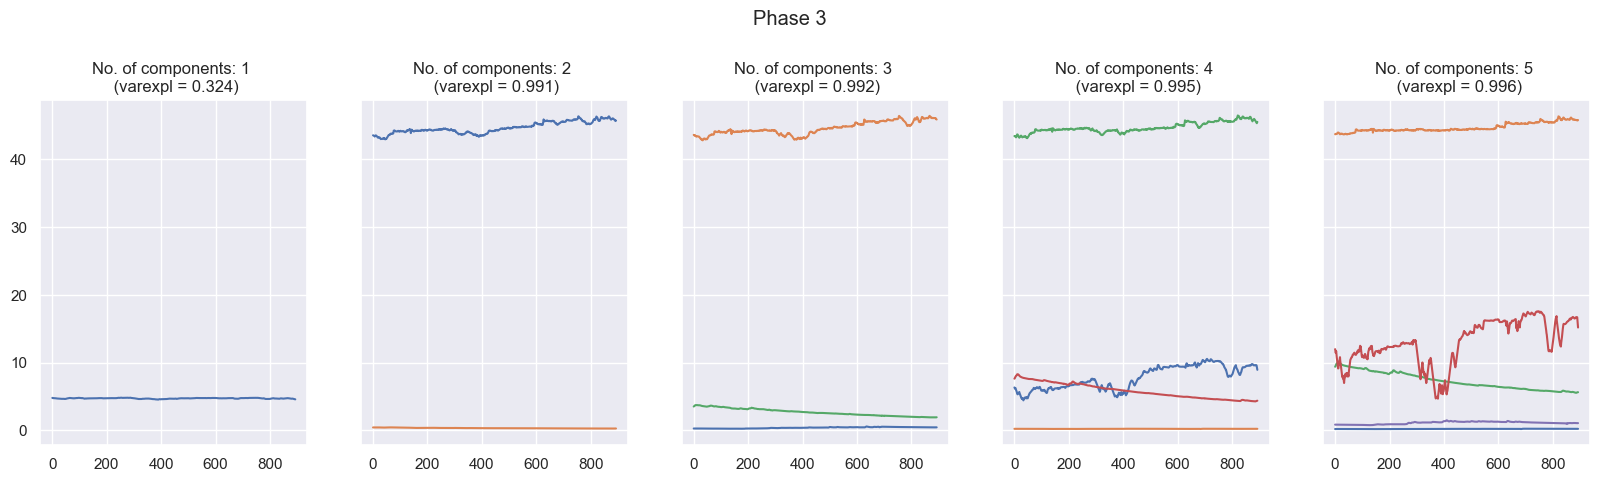

In [33]:
for i in range(1,4):
    plot_different_n_components(EDA_phases, i, n_components_list)

## TEMP

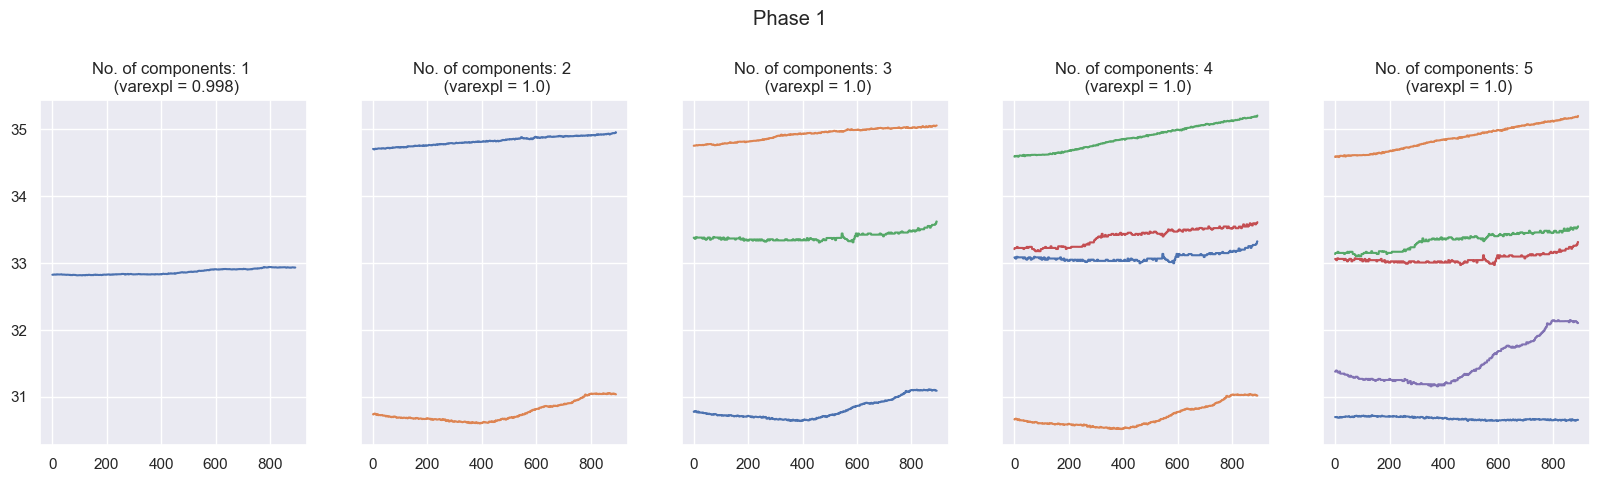

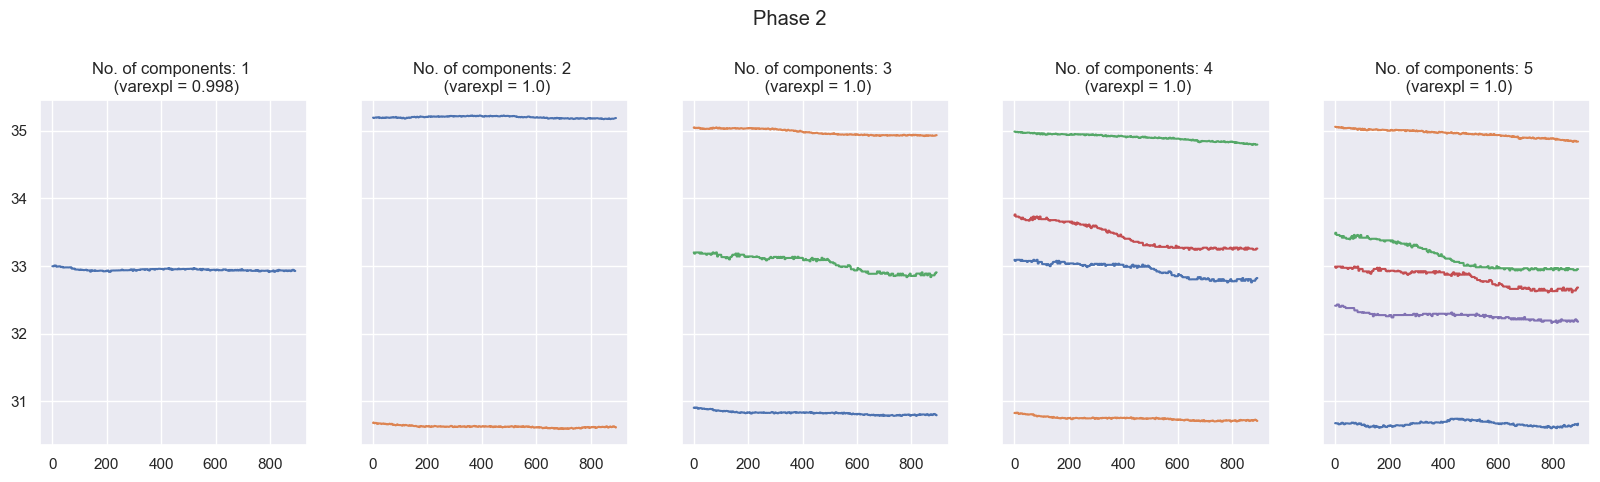

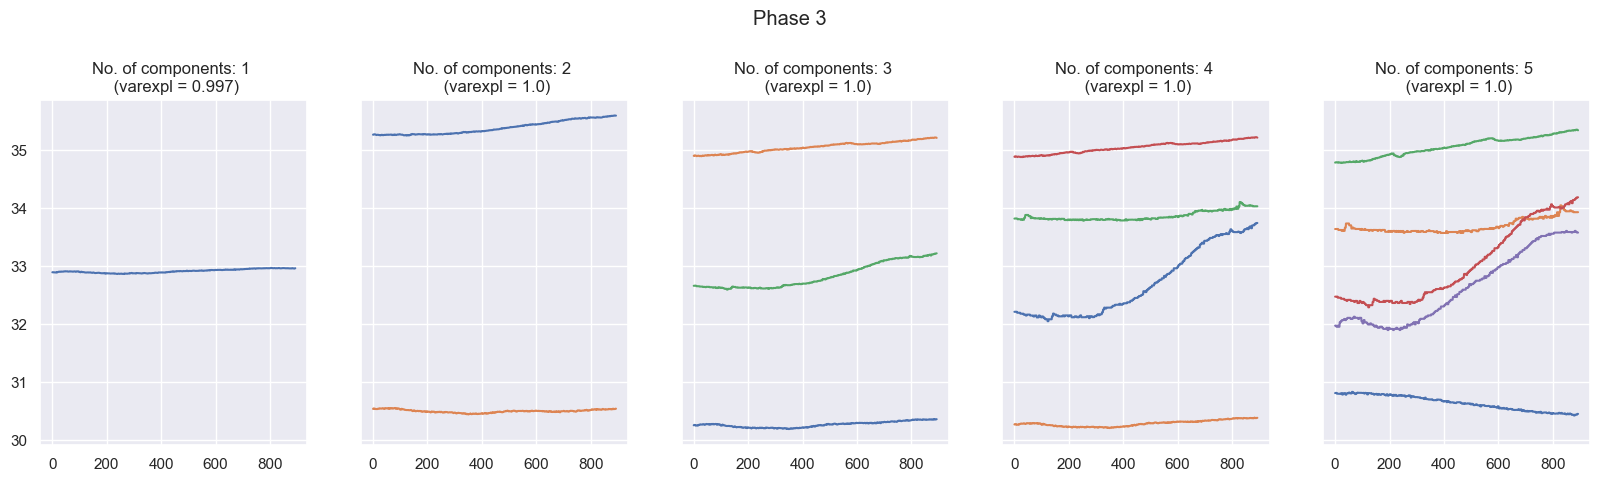

In [34]:
for i in range(1,4):
    plot_different_n_components(TEMP_phases, i, n_components_list)

## BVP

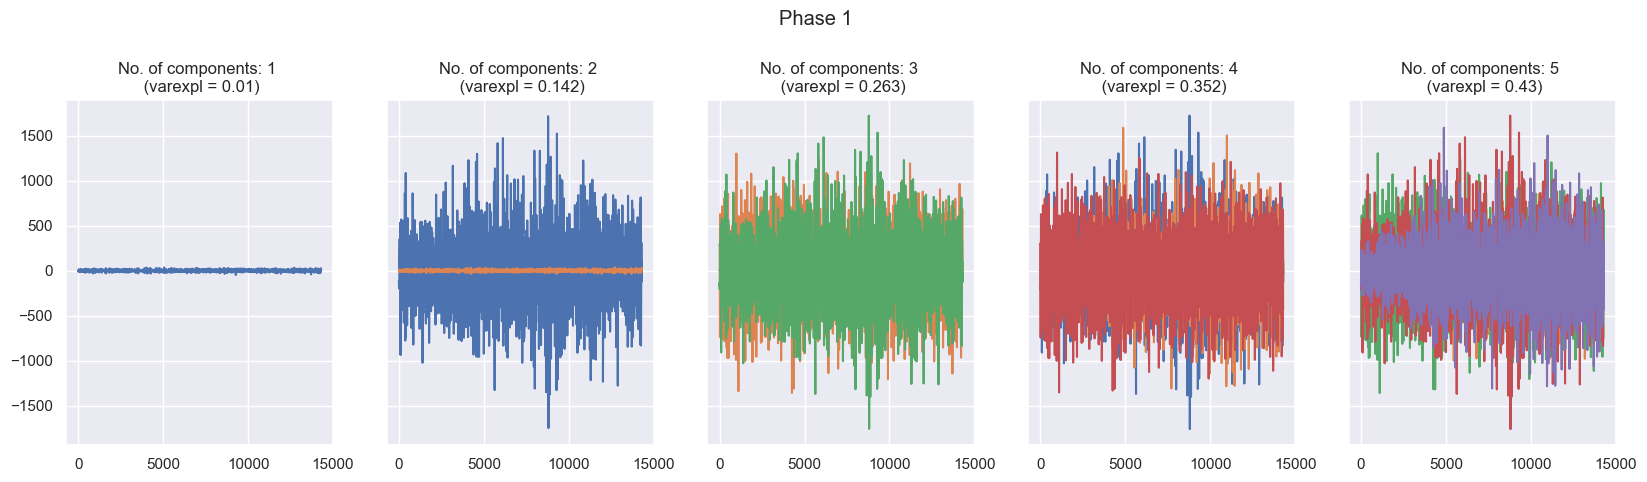

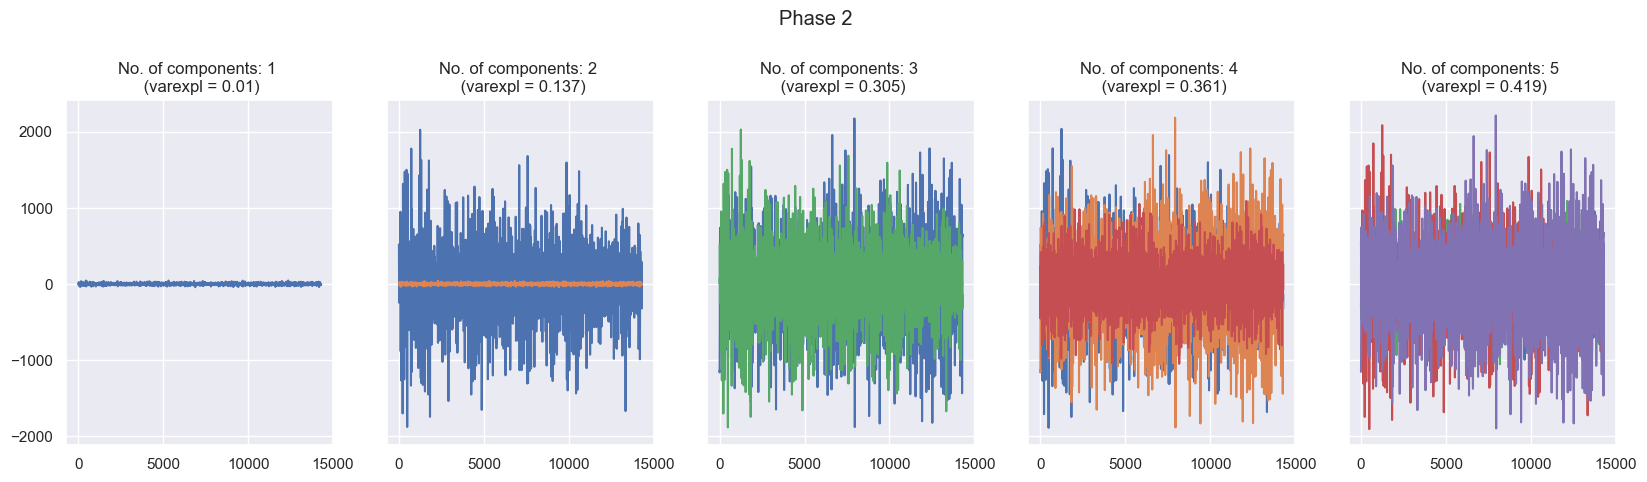

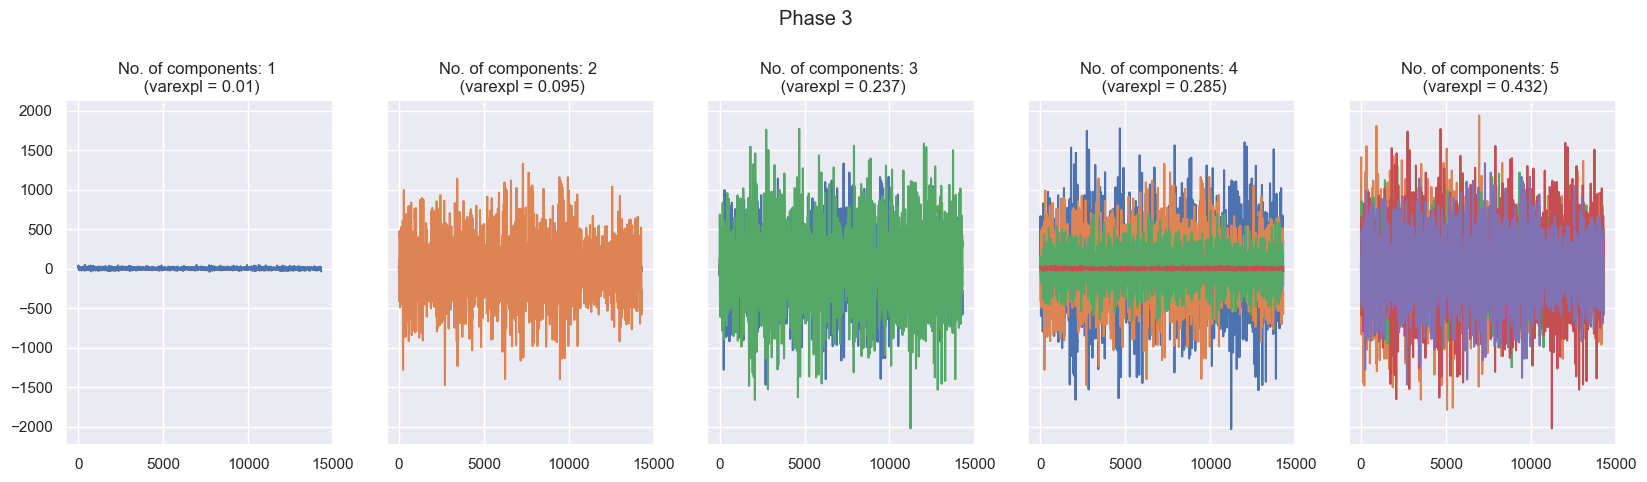

In [35]:
for i in range(1,4):
    plot_different_n_components(BVP_phases, i, n_components_list)

Notes:

- When a single component explains much of the varinace, it means that the signals on average are very similar.
- In general, we see that the explained variance increases for each added component.

# Archetypal Analysis - tsfresh features

In [45]:
# Get data in right format
raw_ds_long = pd.melt(raw_ds.reset_index(), id_vars=['Path'], var_name="Time", value_name="HR")

# Extract features
from tsfresh import extract_features
extracted_features = extract_features(raw_ds_long, column_id="Path", column_sort="Time")

# Impute 
from tsfresh.utilities.dataframe_functions import impute
impute(extracted_features)

# Scale data in two ways
from sklearn.preprocessing import StandardScaler
scaled_features_ss = StandardScaler().fit_transform(extracted_features)

from sklearn.preprocessing import MinMaxScaler
scaled_features_mms = MinMaxScaler().fit_transform(extracted_features)

Feature Extraction: 100%|██████████| 10/10 [00:23<00:00,  2.33s/it]
/Users/sim/Library/Python/3.8/lib/python/site-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['HR__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


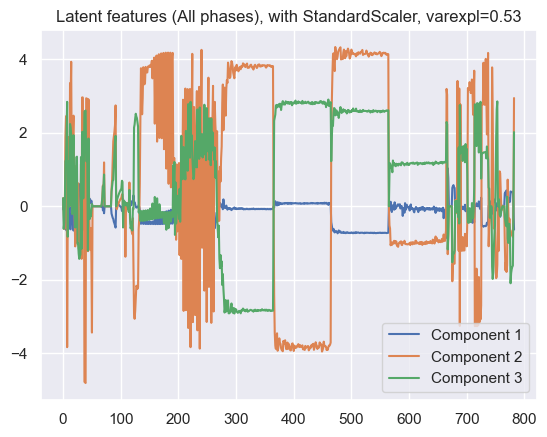

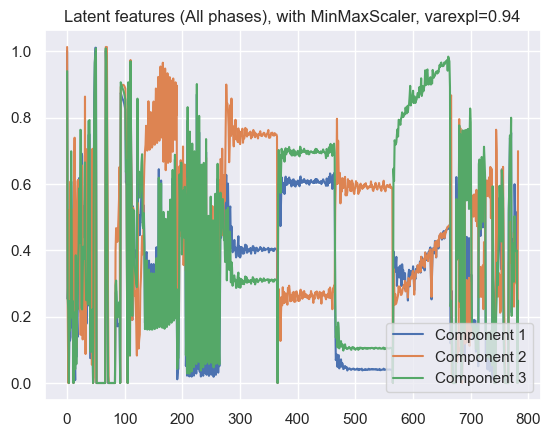

In [44]:
n_components = 3

# With StandardScaler
X = scaled_features_ss
XC, S, C, SSE, varexpl = py_pcha.PCHA(np.asarray(X.T), noc=n_components, delta=0.1)
S = np.asarray(S)
C = np.asarray(C)
X_hat = X.T @ C @ S
L = 0.5*np.linalg.norm(X.T-X_hat)**2
components = np.asarray(XC.T)
plt.figure()
plt.title(f"Latent features (All phases), with StandardScaler, varexpl={round(varexpl,2)}")
for i in range(components.shape[0]):
    plt.plot(components[i, :], label=f"Component {i+1}")
plt.legend(loc='lower right')
plt.show()

# With MinMaxScaler
X = scaled_features_mms
XC, S, C, SSE, varexpl = py_pcha.PCHA(np.asarray(X.T), noc=n_components, delta=0.1)
S = np.asarray(S)
C = np.asarray(C)
X_hat = X.T @ C @ S
L = 0.5*np.linalg.norm(X.T-X_hat)**2
components = np.asarray(XC.T)
plt.figure()
plt.title(f"Latent features (All phases), with MinMaxScaler, varexpl={round(varexpl,2)}")
for i in range(components.shape[0]):
    plt.plot(components[i, :], label=f"Component {i+1}")
plt.legend(loc='lower right')
plt.show()